# Compile Tuned models

We grab the tuned models (performed using the Levenberg Marquadt algorithm on the Sciama HPC).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import json
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from gzbuilder_analysis.parsing import unmake_json
from gzbuilder_analysis.fitting import Model, loss
import lib.galaxy_utilities as gu

In [3]:
AGG_MODEL_PATH = 'output_files/tuned_models/agg'
BI_MODEL_PATH = 'output_files/tuned_models/bi'

In [4]:
diff_data_df = pd.read_pickle('lib/fitting_metadata.pkl')

In [5]:
def make_model(subject_id, m):
    psf = gu.get_psf(subject_id)
    dd = diff_data_df.loc[subject_id]
    pixel_mask = dd['pixel_mask'][::-1]
    galaxy_data = dd['galaxy_data'][::-1]
    return Model(m, galaxy_data, psf=psf, pixel_mask=pixel_mask)

In [6]:
available_agg_models = [
  i for i in os.listdir(AGG_MODEL_PATH)
  if re.match(r'[0-9]+\.json', i)
]
available_bi_models = [
  i for i in os.listdir(BI_MODEL_PATH)
  if re.match(r'[0-9]+\.json', i)
]

As the original data was scaled to be between 0 and 1, we should reverse that scaling before quoting MSE / Likelihoods:

$$L_\mathrm{scaled} = (y - Y)^2 / N$$
$$L =\frac{1}{N}(\frac{10s}{8}y - sY)^2 = \frac{s^2(\frac{10}{8}y - Y)^2}{N}$$

Where $Y$ is the galaxy data, and $y$ is the rendered model

In [7]:
agg_models = pd.Series([])
agg_losses = pd.Series([]).rename('agg_loss')
with tqdm(available_agg_models, desc='Aggregate') as bar:
  for f in bar:
    subject_id = int(f.split('.')[0])
    with open(os.path.join(AGG_MODEL_PATH, f)) as f_in:
      model = unmake_json(json.load(f_in))
    model_obj = make_model(subject_id, model)
    agg_models[subject_id] = model_obj

    r = model_obj.render()
    agg_losses[subject_id] = loss(
      r,
      model_obj.data,
      pixel_mask=model_obj.pixel_mask,
    )

Aggregate: 100%|██████████| 296/296 [02:56<00:00,  2.17it/s]


In [8]:
bi_models = pd.Series([])
bi_losses = pd.Series([]).rename('bi_loss')
with tqdm(available_bi_models, desc='Best Individual') as bar:
  for f in bar:
    subject_id = int(f.split('.')[0])
    with open(os.path.join(BI_MODEL_PATH, f)) as f_in:
      model = unmake_json(json.load(f_in))
    model_obj = make_model(subject_id, model)
    bi_models[subject_id] = model_obj
    r = model_obj.render(model_obj._model)
    bi_losses[subject_id] = loss(
      r,
      model_obj.data,
      pixel_mask=model_obj.pixel_mask,
    )

Best Individual: 100%|██████████| 296/296 [03:04<00:00,  2.10it/s]


In [9]:
print('Saving fitted models')
fitted_models = pd.DataFrame([], columns=('agg', 'bi', 'agg_loss', 'bi_loss'))
for i in bi_models.index:
  fitted_models.loc[i] = dict(
    agg=agg_models.loc[i]._model,
    bi=bi_models.loc[i]._model,
    agg_loss=agg_losses.loc[i],
    bi_loss=bi_losses.loc[i],
  )
fitted_models.to_pickle('lib/fitted_models.pickle')

Saving fitted models


Let's have a look at a selection of residuals:

In [10]:
model_data = agg_models.apply(lambda m: m.data)
residuals = agg_models.apply(lambda m: (m.cached_render(m._model) / 0.8 - m.data)*m.pixel_mask)
multipliers = pd.Series(residuals.index, index=residuals.index).apply(lambda i: gu.get_diff_data(i)['multiplier'])

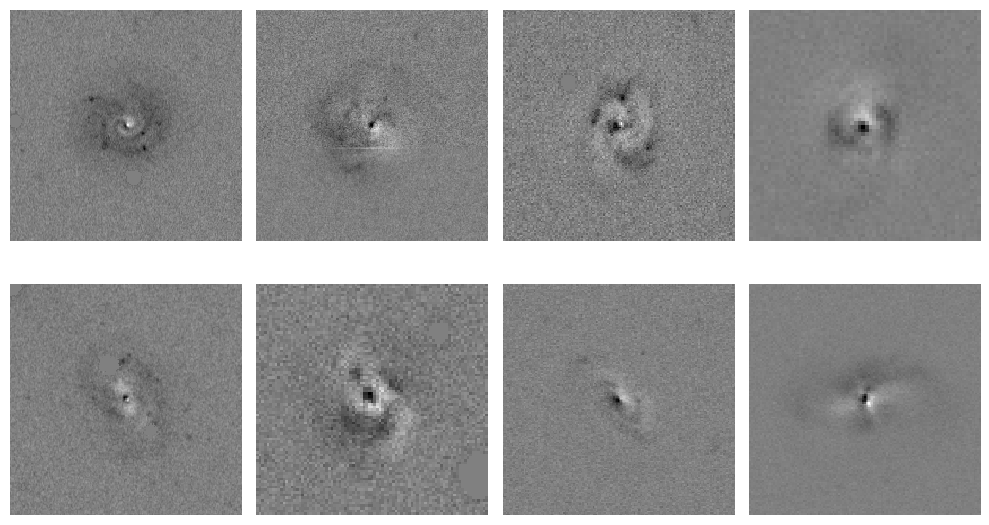

In [11]:
f, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 6), dpi=100)
# example indices
idxs = [21096864, 21686503, 20902009, 21686601, 21096948, 21686589,
       21686560, 20902038]
for i, ax in enumerate(j for i in axs for j in i):
  sid = idxs[i]
  r = residuals.loc[sid] * multipliers.loc[sid]
  l = np.abs(r).max()
  ax.imshow(r, vmin=-l, vmax=l, cmap='gray')
  ax.axis('off')
plt.tight_layout()

Text(0.5, 1.0, 'Tuned Agg loss: 9.8340e-05')

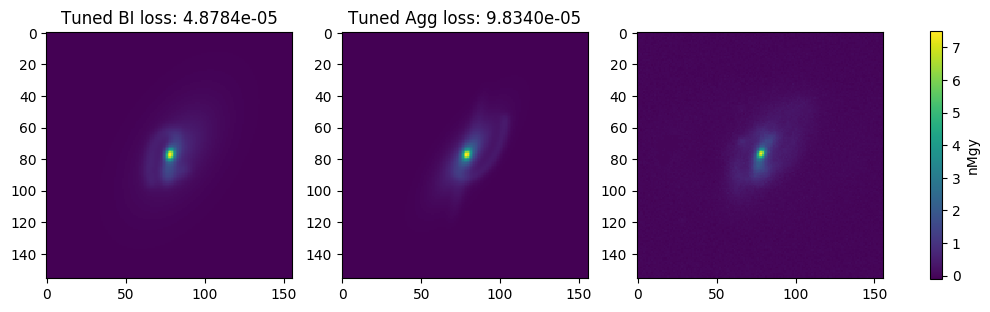

In [12]:
m = gu.get_diff_data(bi_models.index[13])['multiplier']
f, ax = plt.subplots(ncols=3, figsize=(12, 4), dpi=100)
ax[0].imshow(bi_models.iloc[13].render() * m / 0.8)
ax[1].imshow(agg_models.iloc[13].render() * m / 0.8)
m = ax[2].imshow(bi_models.iloc[13].data * m)
c = plt.colorbar(m, ax=ax, shrink=0.82, fraction=0.05)
c.set_label('nMgy')
ax[0].set_title('Tuned BI loss: {:.4e}'.format(bi_losses.iloc[13]))
ax[1].set_title('Tuned Agg loss: {:.4e}'.format(agg_losses.iloc[13]))

What is the relative change in MSE compared to an empty model? (where MSE with a model is better, else we have had a fitting problem)

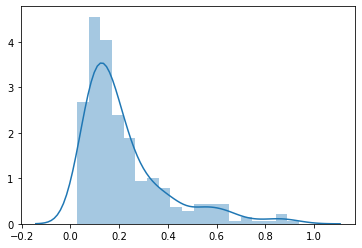

In [13]:
M = agg_models.apply(lambda m: (m.cached_render(m._model)**2).sum() / m.data.size)
sns.distplot((agg_losses / M)[agg_losses / M < 1])

And how does the tuned best individual stack up against the tuned aggregate?

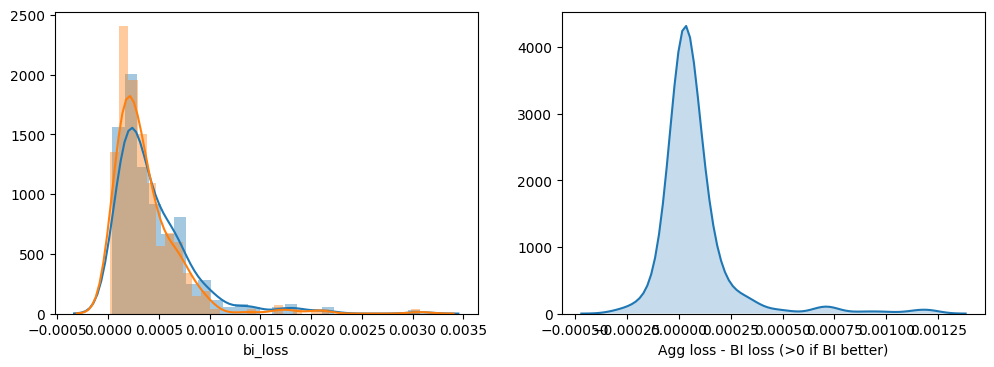

In [14]:
_, axs = plt.subplots(ncols=2, figsize=(12, 4), dpi=100)
plt.sca(axs[0])
sns.distplot(agg_losses)
sns.distplot(bi_losses)

plt.sca(axs[1])
diff = agg_losses - bi_losses
sns.kdeplot(diff.dropna(), shade=True)
plt.xlabel('Agg loss - BI loss (>0 if BI better)')
l = plt.ylim()[1]
plt.ylim(0, l);

Who wins? (and with what probability!)

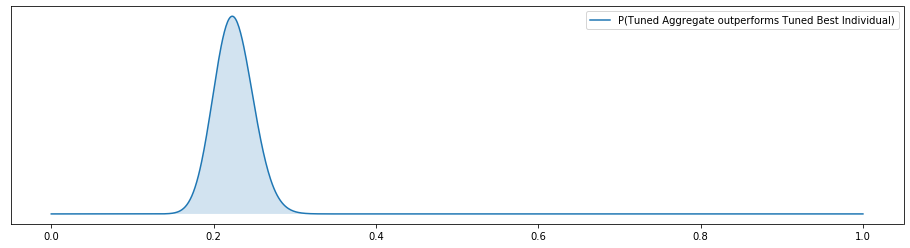

In [15]:
x = np.linspace(0, 1, 1000)
p_agg_better = st.beta.pdf(x, 1 + (diff < 0).sum(), 1 + len(diff) - (diff < 0).sum())
plt.figure(figsize=(16, 4))
plt.plot(x, p_agg_better, label='P(Tuned Aggregate outperforms Tuned Best Individual)')
plt.fill_between(x, 0, p_agg_better, alpha=0.2)
plt.legend()
plt.yticks([]);

What do the models look like where the differences between aggregate and models are largest?

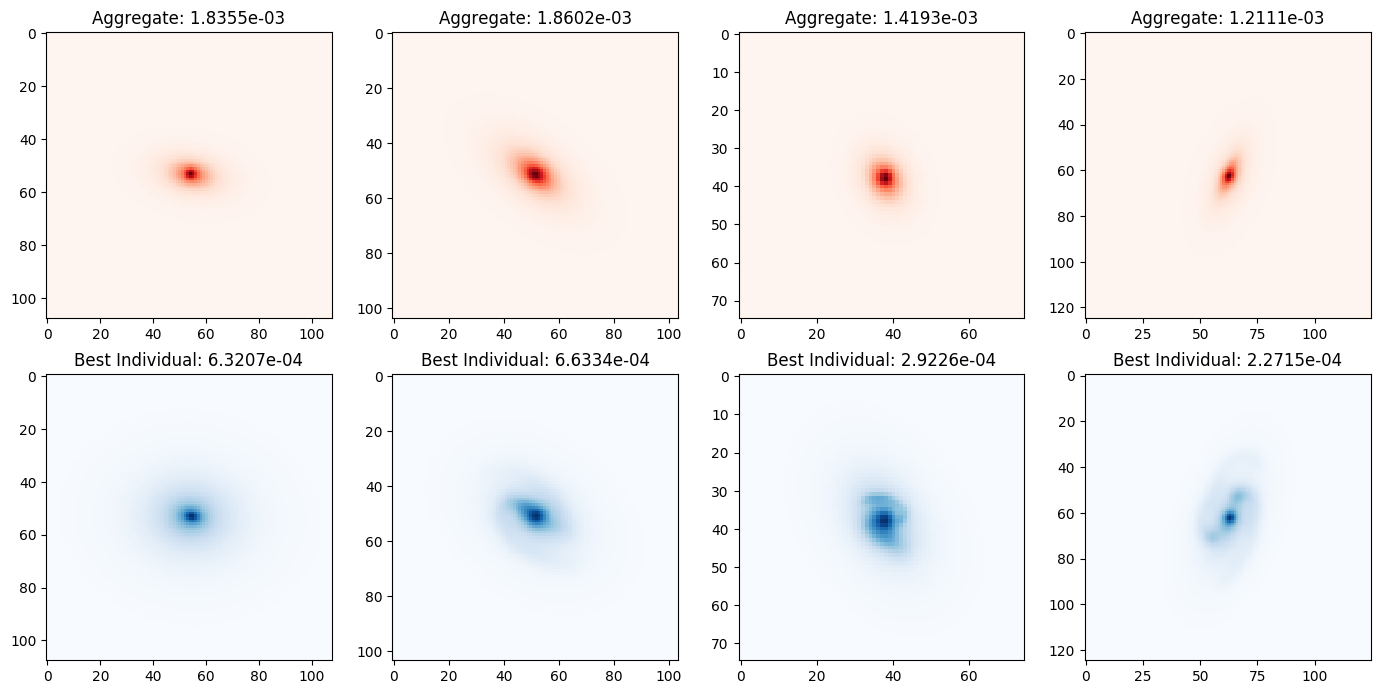

In [16]:
_, ax = plt.subplots(nrows=2, ncols=4, figsize=(14, 7), dpi=100)
for i, idx in enumerate(diff.abs().sort_values(ascending=False).index[:4]):
  agg_better = agg_losses.loc[idx] < bi_losses.loc[idx]
  a = agg_models.loc[idx]
  b = bi_models.loc[idx]
  ax[0][i].imshow(a.render() * a.pixel_mask ,
                  cmap=('Blues' if agg_better else 'Reds'))
  ax[0][i].set_title('Aggregate: {:.4e}'.format(agg_losses.loc[idx]))
  ax[1][i].imshow(b.render() * b.pixel_mask,
                  cmap=('Reds' if agg_better else 'Blues'))
  ax[1][i].set_title('Best Individual: {:.4e}'.format(bi_losses.loc[idx]))
plt.tight_layout()

We see that the aggregate sometimes loses the secondary components which allow the best individual to properly account for the internal structure of the galaxy.

How do the residuals measure up? Without a proper sigma image we can't obtain a likelihood, but we can measure what proportion of light has been accounted for

$$R_\mathrm{max} = \frac{\max(|D_i - M_i|)}{\mathrm{max}(D_i)}$$
$$R_\mathrm{sum} = \frac{\sum_{i=0}^N|D_i - M_i|}{\sum_{i=0}^N|D_i|}$$

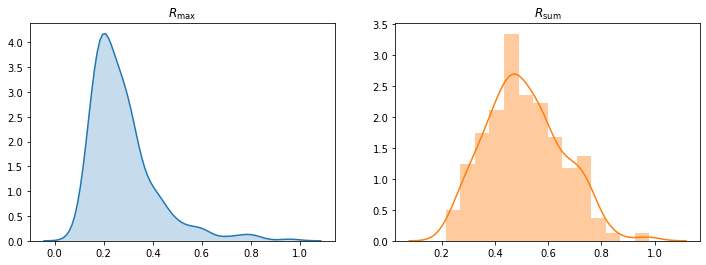

In [17]:
residual_max = (residuals * multipliers).apply(lambda m: np.max(np.abs(m)))
# residual_median = (residuals * multipliers).apply(lambda m: np.median(np.abs(m)))
residual_sum = (residuals * multipliers).apply(lambda m: np.sum(np.abs(m)))
model_sum = (model_data * multipliers).apply(lambda m: np.sum(np.abs(m)))
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title('$R_\mathrm{max}$')
sns.kdeplot(residual_max / multipliers, shade=True)
plt.subplot(122)
plt.title('$R_\mathrm{sum}$')
sns.distplot(residual_sum / model_sum, color='C1')

In [18]:
display((residual_max / multipliers).describe().rename('Max pivot'))
display((residual_sum / model_sum).describe().rename('Sum pivot'))

count    296.000000
mean       0.277969
std        0.132053
min        0.083064
25%        0.186514
50%        0.242742
75%        0.319889
max        0.958708
Name: Max pivot, dtype: float64

count    296.000000
mean       0.510334
std        0.142992
min        0.215684
25%        0.411161
50%        0.496443
75%        0.603844
max        0.980386
Name: Sum pivot, dtype: float64